Вариант 3 Face Recognition/Verification

In [ ]:
import os
import cv2
import time
import random
import numpy as np
import math
import pandas as pd

import tensorflow as tf
from keras.applications import MobileNetV3Small
from keras.models import Model
from keras import layers, backend, metrics
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Lambda

import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import plot_model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [ ]:
!unzip "/content/Extracted_Faces.zip" -d "/content/Extracted_Faces/"

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: /content/Extracted_Faces/Extracted Faces/1095/2.jpg  
  inflating: /content/Extracted_Faces/Extracted Faces/1095/3.jpg  
  inflating: /content/Extracted_Faces/Extracted Faces/1119/0.jpg  
  inflating: /content/Extracted_Faces/Extracted Faces/1119/1.jpg  
  inflating: /content/Extracted_Faces/Extracted Faces/560/0.jpg  
  inflating: /content/Extracted_Faces/Extracted Faces/560/1.jpg  
  inflating: /content/Extracted_Faces/Extracted Faces/560/2.jpg  
  inflating: /content/Extracted_Faces/Extracted Faces/1603/0.jpg  
  inflating: /content/Extracted_Faces/Extracted Faces/1603/1.jpg  
  inflating: /content/Extracted_Faces/Extracted Faces/1217/0.jpg  
  inflating: /content/Extracted_Faces/Extracted Faces/1217/1.jpg  
  inflating: /content/Extracted_Faces/Extracted Faces/1217/4.jpg  
  inflating: /content/Extracted_Faces/Extracted Faces/1217/2.jpg  
  inflating: /content/Extracted_Faces/Extracted Faces/1217/3.jpg

In [ ]:
random.seed(5)
np.random.seed(5)
tf.random.set_seed(5)

ROOT = "/content/Extracted_Faces/Extracted Faces"

def read_image(index):
    path = os.path.join(ROOT, index[0], index[1])
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
def split_dataset(directory, split=0.9):
    folders = os.listdir(directory)
    num_train = int(len(folders)*split)

    random.shuffle(folders)

    train_list, test_list = {}, {}

    for folder in folders[:num_train]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        train_list[folder] = num_files

    for folder in folders[num_train:]:
        num_files = len(os.listdir(os.path.join(directory, folder)))
        test_list[folder] = num_files

    return train_list, test_list

In [ ]:
train_list, test_list = split_dataset(ROOT, split=0.9)
print("Length of training list:", len(train_list))
print("Length of testing list :", len(test_list))

print("\nTest List:", test_list)

Length of training list: 1191
Length of testing list : 133

Test List: {'724': 2, '1120': 4, '394': 4, '188': 4, '267': 2, '1679': 4, '435': 7, '545': 3, '491': 2, '355': 2, '1414': 7, '305': 6, '1125': 2, '1421': 9, '565': 2, '1499': 3, '344': 2, '160': 2, '1567': 4, '816': 3, '582': 2, '717': 5, '988': 4, '1263': 2, '1187': 2, '852': 2, '735': 2, '1652': 21, '619': 2, '1400': 2, '1506': 2, '1248': 2, '1274': 2, '721': 12, '914': 2, '874': 2, '92': 4, '1387': 5, '1418': 2, '378': 11, '1186': 2, '1312': 4, '649': 12, '1584': 29, '1471': 8, '33': 2, '676': 3, '785': 3, '173': 5, '996': 2, '1110': 3, '1148': 2, '1090': 3, '575': 3, '1092': 17, '1412': 3, '1441': 2, '910': 5, '1309': 4, '1439': 3, '319': 2, '356': 3, '860': 2, '929': 2, '428': 5, '1265': 4, '604': 3, '596': 2, '1036': 2, '560': 3, '436': 2, '1568': 12, '870': 3, '422': 4, '198': 2, '1063': 3, '1282': 2, '243': 3, '345': 5, '839': 2, '621': 7, '117': 33, '272': 5, '727': 8, '954': 4, '254': 2, '1070': 2, '1609': 2, '1062':

In [ ]:
def create_triplets(directory, folder_list, max_files=10):
    triplets = []
    folders = list(folder_list.keys())

    for folder in folders:
        path = os.path.join(directory, folder)
        files = list(os.listdir(path))[:max_files]
        num_files = len(files)

        for i in range(num_files-1):
            for j in range(i+1, num_files):
                anchor = (folder, f"{i}.jpg")
                positive = (folder, f"{j}.jpg")
                triplets.append((anchor, positive))

    random.shuffle(triplets)
    return triplets

In [ ]:
train_triplet = create_triplets(ROOT, train_list)
test_triplet  = create_triplets(ROOT, test_list)

print("Number of training triplets:", len(train_triplet))
print("Number of testing triplets :", len(test_triplet))

print("\nExamples of triplets:")
for i in range(10):
    print(train_triplet[i])

Number of training triplets: 10062
Number of testing triplets : 1169

Examples of triplets:
(('0', '1.jpg'), ('0', '2.jpg'))
(('1202', '0.jpg'), ('1202', '5.jpg'))
(('1061', '4.jpg'), ('1061', '5.jpg'))
(('691', '7.jpg'), ('691', '8.jpg'))
(('559', '1.jpg'), ('559', '9.jpg'))
(('1478', '0.jpg'), ('1478', '1.jpg'))
(('573', '1.jpg'), ('573', '2.jpg'))
(('1524', '2.jpg'), ('1524', '4.jpg'))
(('824', '6.jpg'), ('824', '7.jpg'))
(('548', '4.jpg'), ('548', '5.jpg'))


In [ ]:
def get_batch(triplet_list, folder_list, ket, batch_size=256, augment=True, shuffle=False):
    batch_steps = len(triplet_list)//batch_size
    if shuffle:
        random.shuffle(triplet_list)
    for i in range(batch_steps+1):
        anchor   = []
        positive = []
        negative = []

        j = i*batch_size
        while j<(i+1)*batch_size and j<len(triplet_list):
            a, p = triplet_list[j]

            neg_key = random.choice(ket)

            while neg_key == p[0]:
                neg_key = random.choice(ket)
            neg_file = random.randint(0, folder_list[neg_key]-1)

            anchor.append(read_image(a))
            positive.append(read_image(p))
            negative.append(read_image((neg_key, f'{neg_file}.jpg')))
            j+=1

        anchor = np.array(anchor)
        positive = np.array(positive)
        negative = np.array(negative)


        yield ([anchor, positive, negative])

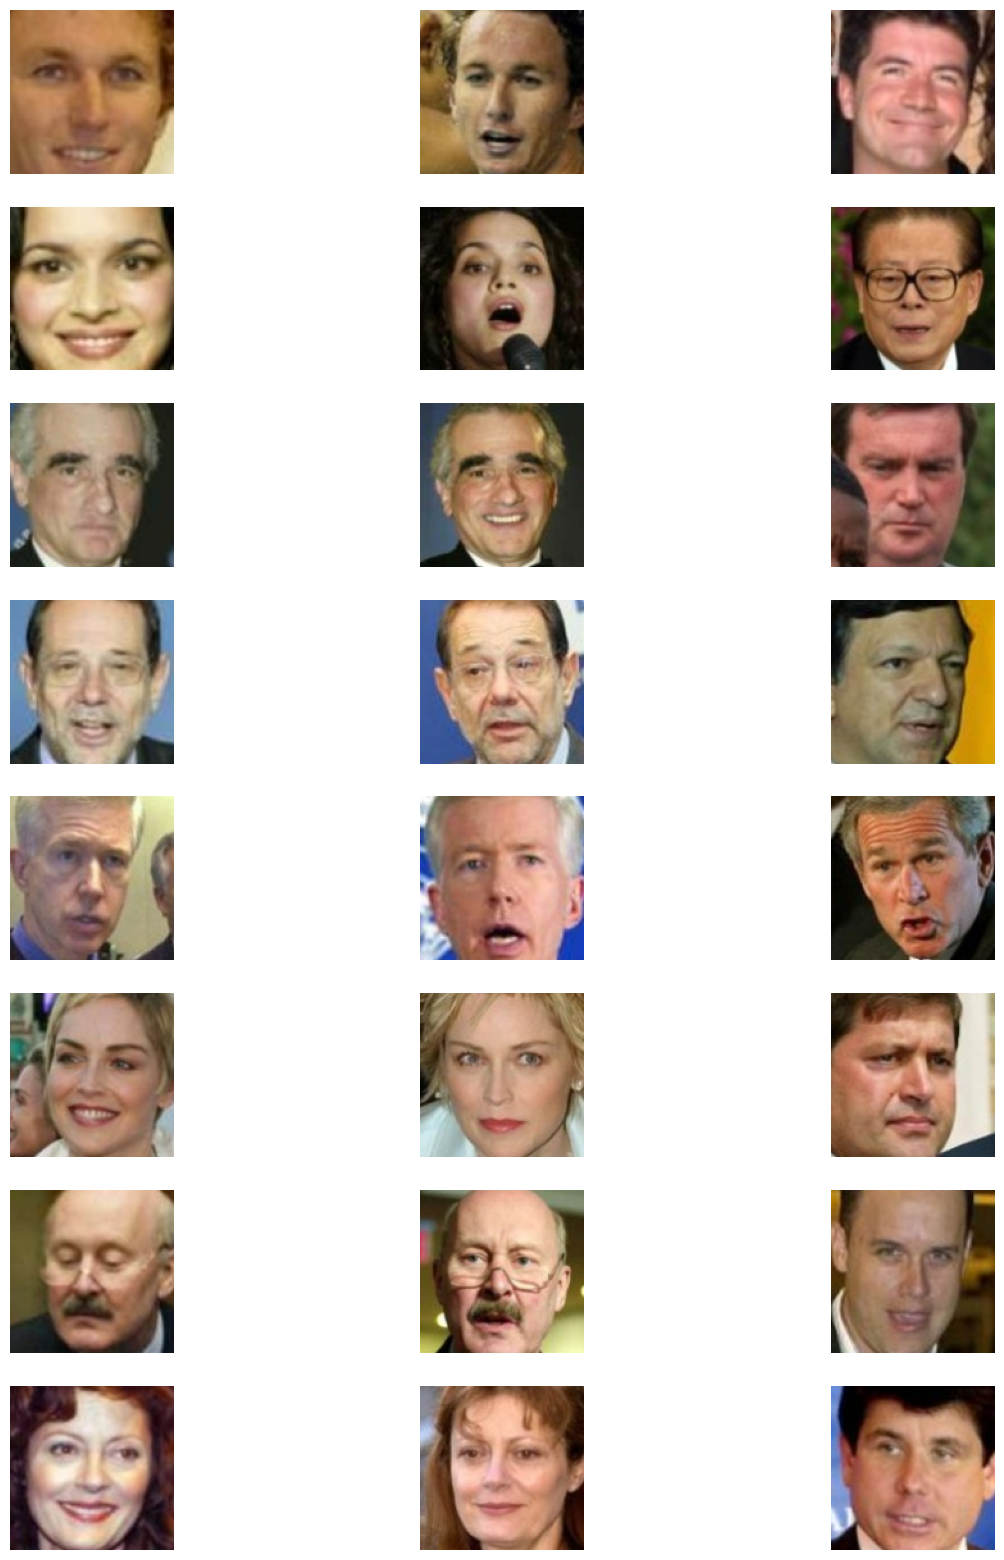

In [ ]:
num_plots = 8

f, axes = plt.subplots(num_plots, 3, figsize=(15, 20))

for a, p, n in get_batch(train_triplet, train_list, list(train_list.keys()), batch_size=num_plots):
    for i in range(num_plots):
        axes[i, 0].imshow(a[i])
        axes[i, 0].axis('off')
        axes[i, 1].imshow(p[i])
        axes[i, 1].axis('off')
        axes[i, 2].imshow(n[i])
        axes[i, 2].axis('off')
    break

plt.show()

In [ ]:
def cnn(input_shape=(128, 128, 3)):
    model = MobileNetV3Small(include_top=False, input_shape=input_shape)
    for idx, layer in enumerate(model.layers[166:]):
        layer.trainable=False

    x = Flatten()(model.layers[-1].output)
    x = Dense(2048, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    output = layers.Lambda(lambda v: tf.math.l2_normalize(v, axis=1))(x)
    return Model(model.inputs, output)

In [ ]:
class EuclidianDistance(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.5)
])

In [ ]:
def Based_Siamese_Network(input_shape=(128, 128, 3)):
    encoder = cnn(input_shape)

    anchor_input   = layers.Input(input_shape, name="Anchor_Input")
    positive_input = layers.Input(input_shape, name="Positive_Input")
    negative_input = layers.Input(input_shape, name="Negative_Input")

    anchor_input = data_augmentation(anchor_input)
    positive_input = data_augmentation(positive_input)
    negative_input = data_augmentation(negative_input)

    encoded_a = encoder(anchor_input)
    encoded_p = encoder(positive_input)
    encoded_n = encoder(negative_input)

    distances = EuclidianDistance()(
        encoder(anchor_input),
        encoder(positive_input),
        encoder(negative_input)
    )

    siamese_network = Model(
        inputs  = [anchor_input, positive_input, negative_input],
        outputs = distances,
        name = "Siamese_Network"
    )
    return siamese_network

In [ ]:
class SiameseModel(Model):
    def __init__(self, siamese_network, margin=1.0, alpha=0.1, epsilon=0.1):
        super(SiameseModel, self).__init__()
        self.epsilon = epsilon
        self.margin = margin
        self.alpha = alpha
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

            gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)


        base_dis = ap_distance - an_distance
        base_loss = tf.maximum(base_dis + self.margin, 0.0)


        return base_loss

    @property
    def metrics(self):
        return [self.loss_tracker]

In [ ]:
siamese_network = Based_Siamese_Network()
siamese_model = SiameseModel(siamese_network, margin=1.5, alpha=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, epsilon=1e-01)
siamese_model.compile(optimizer=optimizer)

4334752/4334752 [==============================] - 0s 0us/step


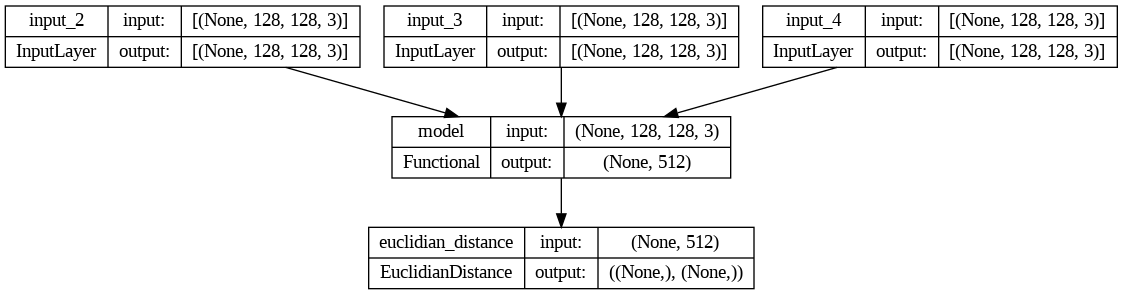

In [ ]:
plot_model(siamese_network, show_shapes=True, show_layer_names=True)

In [ ]:
def test_on_triplets(model, triplet_list, folder_list, keys, batch_size=256, threshold=1):
    pos_scores, neg_scores = [], []

    for data in get_batch(triplet_list, folder_list, keys, batch_size=batch_size):
        prediction = model.predict(data, verbose=0)
        pos_scores += list(prediction[0])
        neg_scores += list(prediction[1])

    pos = np.array(pos_scores)
    neg = np.array(neg_scores)

    accuracy = (np.sum(pos < neg)) / len(pos_scores)
    ap_mean = np.mean(pos_scores)
    an_mean = np.mean(neg_scores)
    ap_stds = np.std(pos_scores)
    an_stds = np.std(neg_scores)

    return (accuracy, ap_mean, an_mean, ap_stds, an_stds)

In [ ]:
SAVE_ALL = False
EPOCHS = 30
BATCH_SIZE = 32
MAX_ACC = 0
TRAIN_LOSS = []
TRAIN_METRICS = []
TRAIN_ACC = []
TEST_METRICS = []
TEST_ACC = []
keta_train = list(train_list.keys())
keta_test = list(test_list.keys())

In [ ]:
for epoch in range(1, EPOCHS+1):
    print('\n Epoch {}/{}'.format(epoch, EPOCHS))
    progbar = tf.keras.utils.Progbar(math.ceil(len(train_triplet)/BATCH_SIZE))
    epoch_loss = []
    for idx, data in enumerate(get_batch(train_triplet, train_list, keta_train, batch_size=BATCH_SIZE)):
        progbar.update(idx+1)
        loss = siamese_model.train_on_batch(data)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    TRAIN_LOSS.append(epoch_loss)

    print(f"Loss on train    = {epoch_loss:.5f}")

    metric_train = test_on_triplets(siamese_model, train_triplet, train_list, keta_train, batch_size=BATCH_SIZE)
    TRAIN_METRICS.append(metric_train)
    TRAIN_ACC.append(metric_train[0])
    print(f"Accuracy on train = {metric_train[0]:.5f}")


    metric_test = test_on_triplets(siamese_model, test_triplet, test_list, keta_test, batch_size=BATCH_SIZE)
    TEST_METRICS.append(metric_test)
    TEST_ACC.append(metric_test[0])
    print(f"Accuracy on test = {metric_test[0]:.5f}")


 Epoch 1/30
315/315 [==============================] - 659s 2s/step
Loss on train    = 0.94134
Accuracy on train = 0.84884
Accuracy on test = 0.81779

 Epoch 2/30
315/315 [==============================] - 631s 2s/step
Loss on train    = 0.66884
Accuracy on train = 0.88322
Accuracy on test = 0.85201

 Epoch 3/30
315/315 [==============================] - 630s 2s/step
Loss on train    = 0.55337
Accuracy on train = 0.90628
Accuracy on test = 0.85458

 Epoch 4/30
315/315 [==============================] - 624s 2s/step
Loss on train    = 0.47251
Accuracy on train = 0.93669
Accuracy on test = 0.85201

 Epoch 5/30
315/315 [==============================] - 620s 2s/step
Loss on train    = 0.42075
Accuracy on train = 0.94226
Accuracy on test = 0.88794

 Epoch 6/30
315/315 [==============================] - 621s 2s/step
Loss on train    = 0.34340
Accuracy on train = 0.95508
Accuracy on test = 0.88708

 Epoch 7/30
315/315 [==============================] - 619s 2s/step
Loss on train    = 0.2987

In [ ]:
siamese_model.save_weights("best_siamese_model")

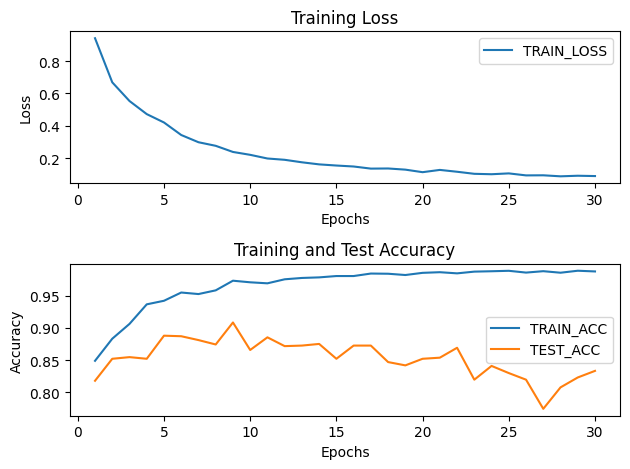

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(range(1, len(TRAIN_LOSS) + 1), TRAIN_LOSS, label='TRAIN_LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(range(1, len(TRAIN_ACC) + 1), TRAIN_ACC, label='TRAIN_ACC')
plt.plot(range(1, len(TEST_ACC) + 1), TEST_ACC, label='TEST_ACC')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
TRAIN_METRICS_mean = np.array(TRAIN_METRICS)
TEST_METRICS_mean = np.array(TEST_METRICS)

TRAIN_METRICS_mean = np.mean(TRAIN_METRICS_mean, axis=0).tolist()
TEST_METRICS_mean = np.mean(TEST_METRICS_mean, axis=0).tolist()
print(TRAIN_METRICS_mean)
print(TEST_METRICS_mean)

[0.9666997946067714, 0.2261930058399836, 1.7691498796145122, 0.3020555237929026, 0.4584620386362076]
[0.8531223267750214, 0.8384079764286677, 1.749809483687083, 0.660940678914388, 0.4637951066096624]


In [ ]:
d = {'METRICS': ['accuracy', 'ap_mean', 'an_mean', 'ap_stds', 'an_stds'],
     'train accuracy': [TRAIN_METRICS_mean[i] for i in range(len(TRAIN_METRICS_mean))],
     'test accuracy': [TEST_METRICS_mean[i] for i in range(len(TEST_METRICS_mean))]}
df = pd.DataFrame(data=d, index=[0, 1, 2, 3, 4])
df

,METRICS,train accuracy,test accuracy
0,accuracy,0.966700,0.853122
1,ap_mean,0.226193,0.838408
2,an_mean,1.769150,1.749809
3,ap_stds,0.302056,0.660941
4,an_stds,0.458462,0.463795


In [ ]:
def extract_encoder(model):
    encoder = cnn((128, 128, 3))
    i=0
    for e_layer in model.layers[0].layers[3].layers:
        layer_weight = e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder

encoder = extract_encoder(siamese_model)
encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 128, 128, 3)          0         ['input_5[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 64, 64, 16)           432       ['rescaling_2[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 64, 64, 16)           64        ['Conv[0][0]']                
 lization)                                                                                  

In [ ]:
def classify_images(face_list1, face_list2, threshold=1):
    tensor1 = encoder.predict(face_list1)
    tensor2 = encoder.predict(face_list2)

    distance = np.sum(np.square(tensor1-tensor2), axis=-1)
    prediction = np.where(distance<=threshold, 0, 1)
    return prediction, distance

1/1 [==============================] - 0s 41ms/step


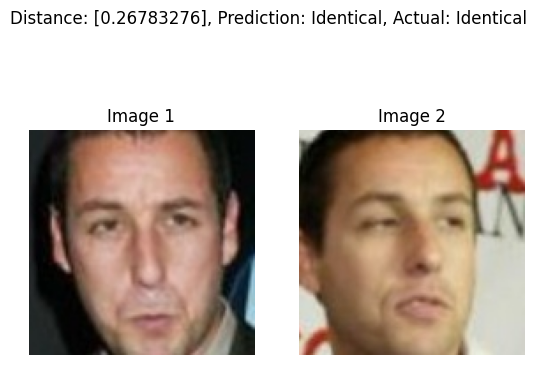

In [ ]:
index_img = '10'

img1 = np.array([read_image((index_img, '0.jpg'))])
img2 = np.array([read_image((index_img, '3.jpg'))])
pred, dist = classify_images(img1, img2)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img1[0])
axes[0].set_title('Image 1')
axes[0].axis('off')
axes[1].imshow(img2[0])
axes[1].set_title('Image 2')
axes[1].axis('off')

plt.suptitle(f"Distance: {dist}, Prediction: {'Identical' if not pred else 'Different'}, Actual: {'Identical'}")
plt.show()

1/1 [==============================] - 0s 39ms/step


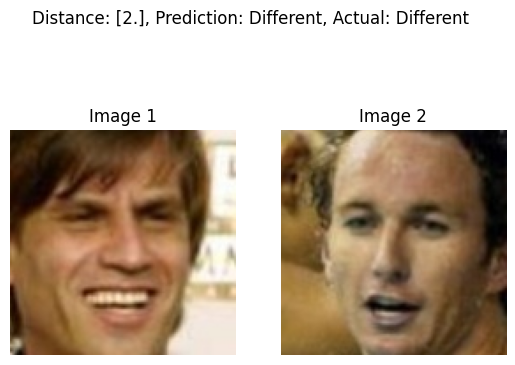

In [ ]:
img1 = np.array([read_image(('1', '0.jpg'))])
img2 = np.array([read_image(('0', '2.jpg'))])
pred, dist = classify_images(img1, img2)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(img1[0])
axes[0].set_title('Image 1')
axes[0].axis('off')
axes[1].imshow(img2[0])
axes[1].set_title('Image 2')
axes[1].axis('off')

plt.suptitle(f"Distance: {dist}, Prediction: {'Identical' if not pred else 'Different'}, Actual: {'Different'}")
plt.show()

8/8 [==============================] - 1s 139ms/step

Accuracy of model: 0.716796875



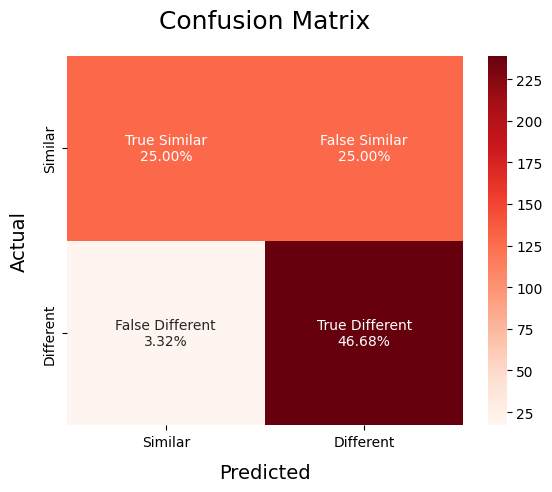

In [ ]:
def ModelMetrics(pos_list, neg_list):
    true = np.array([0]*len(pos_list)+[1]*len(neg_list))
    pred = np.append(pos_list, neg_list)

    print(f"\nAccuracy of model: {accuracy_score(true, pred)}\n")

    cf_matrix = confusion_matrix(true, pred)

    categories  = ['Similar','Different']
    names = ['True Similar','False Similar', 'False Different','True Different']
    percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Reds',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

    return accuracy_score(true, pred)

pos_list = np.array([])
neg_list = np.array([])

for data in get_batch(test_triplet, test_list, keta_test, batch_size=256):
    a, p, n = data
    pos_list = np.append(pos_list, classify_images(a, p)[0])
    neg_list = np.append(neg_list, classify_images(a, n)[0])
    break

model_metrics = ModelMetrics(pos_list, neg_list)